# Policy gradients


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
batch[0], batch[0][1].shape

([0,
  array([-0.02969734, -0.2291498 ,  0.03825211,  0.31902054]),
  1.0,
  False,
  {}],
 (4,))

In [5]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [6]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 bool
1 0
2
1.0 1.0
2.5901655174272826 -3.0681753027576413


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [7]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return states, actions, targetQs

In [102]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [103]:
def model_loss(states, actions, targetQs, # model input
               action_size, hidden_size): # model init
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    loss = tf.reduce_mean(tf.square(Qs - targetQs))
    #loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs, labels=tf.nn.sigmoid(targetQs)))    
    #loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, labels=actions_labels))        
    return actions_logits, loss

In [104]:
def model_opt(loss, learning_rate):
    """
    Get optimization operations in order
    :param loss: Generator loss Tensor for action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [105]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input
        
        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [106]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print(np.max(actions) - np.min(actions)+1)
print(np.max(actions))
print(np.min(actions))

state size:(500, 4) actions:(500,)
2
1
0


In [107]:
# Training parameters
train_episodes = 1000          # max number of episodes to learn from
max_steps = 300000000          # max steps in an episode
learning_rate = 0.001          # learning rate for adam

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
batch_size = 1000              # number of samples in the memory/ experience as mini-batch size

In [108]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)

In [109]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [110]:
env.reset()

array([0.04877953, 0.03200295, 0.02666338, 0.01881202])

In [111]:
# TF session for training
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    state = env.reset()
    
    # Make a bunch of random actions and store the experiences
    # Training steps/batches
    for _ in range(batch_size): # start=0, step=1, stop=max_steps/done/reward
        #action = env.action_space.sample()
        action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
        action = np.argmax(action_logits)
        next_state, reward, done, _ = env.step(action)
        memory.buffer.append([state, action, done])
        state = next_state
        if done is True:
            # Initialize the simulation
            state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [112]:
state, reward, action

(array([ 0.04273696, -0.56210866, -0.00363781,  0.83491028]), 1.0, 0)

In [116]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list, loss_list = [], []

# TF session for training
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(train_episodes):
        state = env.reset() # env first state
        batch = [] # every data batch
        total_reward = 0
        #loss_batch = []

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, done])
            state = next_state
            total_reward += reward            
            
            batch = memory.buffer
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            dones = np.array([each[2] for each in batch])
            actions_logits = sess.run(model.actions_logits, feed_dict={model.states: states})
            Qs = np.max(actions_logits, axis=1)
            targetQs = Qs * (1 - dones.astype(float))
            loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.actions: actions,
                                                                     model.states: states,
                                                                     model.targetQs: targetQs})
            #loss_batch.append(loss)
            if done is True:
                break
                
        print('Episode: {}'.format(ep),
              'Total reward: {}'.format(total_reward),
              #'Batch loss: {:.9f}'.format(np.mean(loss_batch)))
              'Batch loss: {:.9f}'.format(loss))
        rewards_list.append([ep, total_reward])
        #loss_list.append((ep, np.mean(loss_batch)))
        loss_list.append((ep, loss))
        
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-qn-test.ckpt')

Episode: 0 Total reward: 38.0 Batch loss: 0.001299940
Episode: 1 Total reward: 117.0 Batch loss: 0.029120553
Episode: 2 Total reward: 15.0 Batch loss: 0.111741729
Episode: 3 Total reward: 11.0 Batch loss: 0.266869187
Episode: 4 Total reward: 12.0 Batch loss: 0.668463647
Episode: 5 Total reward: 93.0 Batch loss: 279.457000732
Episode: 6 Total reward: 15.0 Batch loss: 635.877990723
Episode: 7 Total reward: 12.0 Batch loss: 1152.710449219
Episode: 8 Total reward: 13.0 Batch loss: 1999.193237305
Episode: 9 Total reward: 16.0 Batch loss: 4294.833984375
Episode: 10 Total reward: 16.0 Batch loss: 7334.770019531
Episode: 11 Total reward: 13.0 Batch loss: 7535.219238281
Episode: 12 Total reward: 18.0 Batch loss: 13162.370117188
Episode: 13 Total reward: 20.0 Batch loss: 19429.863281250
Episode: 14 Total reward: 20.0 Batch loss: 35924.257812500
Episode: 15 Total reward: 14.0 Batch loss: 56754.542968750
Episode: 16 Total reward: 13.0 Batch loss: 78235.359375000
Episode: 17 Total reward: 18.0 Batc

Episode: 132 Total reward: 11.0 Batch loss: 2564175104.000000000
Episode: 133 Total reward: 10.0 Batch loss: 2525939456.000000000
Episode: 134 Total reward: 11.0 Batch loss: 2529301504.000000000
Episode: 135 Total reward: 11.0 Batch loss: 2502242048.000000000
Episode: 136 Total reward: 11.0 Batch loss: 2481544192.000000000
Episode: 137 Total reward: 10.0 Batch loss: 2453150208.000000000
Episode: 138 Total reward: 10.0 Batch loss: 2445878528.000000000
Episode: 139 Total reward: 11.0 Batch loss: 2366974208.000000000
Episode: 140 Total reward: 10.0 Batch loss: 2364023552.000000000
Episode: 141 Total reward: 9.0 Batch loss: 2360877568.000000000
Episode: 142 Total reward: 12.0 Batch loss: 2446184960.000000000
Episode: 143 Total reward: 9.0 Batch loss: 2447512576.000000000
Episode: 144 Total reward: 11.0 Batch loss: 2462955008.000000000
Episode: 145 Total reward: 12.0 Batch loss: 2489217792.000000000
Episode: 146 Total reward: 9.0 Batch loss: 2496807424.000000000
Episode: 147 Total reward: 2

Episode: 259 Total reward: 11.0 Batch loss: 3553452800.000000000
Episode: 260 Total reward: 10.0 Batch loss: 3715393536.000000000
Episode: 261 Total reward: 46.0 Batch loss: 3489641216.000000000
Episode: 262 Total reward: 11.0 Batch loss: 3738201088.000000000
Episode: 263 Total reward: 9.0 Batch loss: 4020050944.000000000
Episode: 264 Total reward: 9.0 Batch loss: 4326455808.000000000
Episode: 265 Total reward: 9.0 Batch loss: 3538064896.000000000
Episode: 266 Total reward: 12.0 Batch loss: 3867945984.000000000
Episode: 267 Total reward: 39.0 Batch loss: 5212215296.000000000
Episode: 268 Total reward: 22.0 Batch loss: 5088610304.000000000
Episode: 269 Total reward: 89.0 Batch loss: 4741508608.000000000
Episode: 270 Total reward: 72.0 Batch loss: 5658311168.000000000
Episode: 271 Total reward: 19.0 Batch loss: 8668805120.000000000
Episode: 272 Total reward: 86.0 Batch loss: 12689615872.000000000
Episode: 273 Total reward: 55.0 Batch loss: 16542578688.000000000
Episode: 274 Total reward:

Episode: 383 Total reward: 26.0 Batch loss: 2760410136576.000000000
Episode: 384 Total reward: 24.0 Batch loss: 2706396151808.000000000
Episode: 385 Total reward: 23.0 Batch loss: 2668788711424.000000000
Episode: 386 Total reward: 29.0 Batch loss: 2644989444096.000000000
Episode: 387 Total reward: 25.0 Batch loss: 2660940120064.000000000
Episode: 388 Total reward: 26.0 Batch loss: 2730351919104.000000000
Episode: 389 Total reward: 25.0 Batch loss: 2632063385600.000000000
Episode: 390 Total reward: 23.0 Batch loss: 2653189046272.000000000
Episode: 391 Total reward: 27.0 Batch loss: 2615008034816.000000000
Episode: 392 Total reward: 21.0 Batch loss: 2634653368320.000000000
Episode: 393 Total reward: 29.0 Batch loss: 2715840937984.000000000
Episode: 394 Total reward: 25.0 Batch loss: 2739068731392.000000000
Episode: 395 Total reward: 23.0 Batch loss: 2729767862272.000000000
Episode: 396 Total reward: 25.0 Batch loss: 2725503565824.000000000
Episode: 397 Total reward: 27.0 Batch loss: 2642

Episode: 505 Total reward: 9.0 Batch loss: 325641568256.000000000
Episode: 506 Total reward: 14.0 Batch loss: 328480915456.000000000
Episode: 507 Total reward: 8.0 Batch loss: 302142619648.000000000
Episode: 508 Total reward: 20.0 Batch loss: 205488832512.000000000
Episode: 509 Total reward: 15.0 Batch loss: 207379103744.000000000
Episode: 510 Total reward: 15.0 Batch loss: 110339489792.000000000
Episode: 511 Total reward: 21.0 Batch loss: 109269319680.000000000
Episode: 512 Total reward: 10.0 Batch loss: 108668600320.000000000
Episode: 513 Total reward: 8.0 Batch loss: 111660621824.000000000
Episode: 514 Total reward: 10.0 Batch loss: 107452145664.000000000
Episode: 515 Total reward: 38.0 Batch loss: 110488010752.000000000
Episode: 516 Total reward: 9.0 Batch loss: 111571501056.000000000
Episode: 517 Total reward: 8.0 Batch loss: 112455966720.000000000
Episode: 518 Total reward: 10.0 Batch loss: 113902551040.000000000
Episode: 519 Total reward: 10.0 Batch loss: 116571856896.000000000


Episode: 629 Total reward: 11.0 Batch loss: 262589775872.000000000
Episode: 630 Total reward: 10.0 Batch loss: 263576436736.000000000
Episode: 631 Total reward: 11.0 Batch loss: 279523524608.000000000
Episode: 632 Total reward: 11.0 Batch loss: 277992341504.000000000
Episode: 633 Total reward: 10.0 Batch loss: 295165689856.000000000
Episode: 634 Total reward: 8.0 Batch loss: 304714383360.000000000
Episode: 635 Total reward: 9.0 Batch loss: 321160871936.000000000
Episode: 636 Total reward: 9.0 Batch loss: 325817237504.000000000
Episode: 637 Total reward: 8.0 Batch loss: 324306370560.000000000
Episode: 638 Total reward: 9.0 Batch loss: 329845571584.000000000
Episode: 639 Total reward: 8.0 Batch loss: 336314007552.000000000
Episode: 640 Total reward: 11.0 Batch loss: 339635404800.000000000
Episode: 641 Total reward: 12.0 Batch loss: 337272406016.000000000
Episode: 642 Total reward: 12.0 Batch loss: 331664293888.000000000
Episode: 643 Total reward: 10.0 Batch loss: 327808614400.000000000
E

Episode: 751 Total reward: 22.0 Batch loss: 306533269504.000000000
Episode: 752 Total reward: 50.0 Batch loss: 141487980544.000000000
Episode: 753 Total reward: 26.0 Batch loss: 173725794304.000000000
Episode: 754 Total reward: 18.0 Batch loss: 173313900544.000000000
Episode: 755 Total reward: 22.0 Batch loss: 174742618112.000000000
Episode: 756 Total reward: 24.0 Batch loss: 176835182592.000000000
Episode: 757 Total reward: 20.0 Batch loss: 184556699648.000000000
Episode: 758 Total reward: 24.0 Batch loss: 179399802880.000000000
Episode: 759 Total reward: 20.0 Batch loss: 178475843584.000000000
Episode: 760 Total reward: 24.0 Batch loss: 170238656512.000000000
Episode: 761 Total reward: 24.0 Batch loss: 179250167808.000000000
Episode: 762 Total reward: 18.0 Batch loss: 170004807680.000000000
Episode: 763 Total reward: 20.0 Batch loss: 171239489536.000000000
Episode: 764 Total reward: 26.0 Batch loss: 192319700992.000000000
Episode: 765 Total reward: 18.0 Batch loss: 185162842112.00000

Episode: 874 Total reward: 20.0 Batch loss: 157549674496.000000000
Episode: 875 Total reward: 24.0 Batch loss: 157549674496.000000000
Episode: 876 Total reward: 32.0 Batch loss: 137446260736.000000000
Episode: 877 Total reward: 30.0 Batch loss: 137446260736.000000000
Episode: 878 Total reward: 23.0 Batch loss: 137446260736.000000000
Episode: 879 Total reward: 26.0 Batch loss: 131405627392.000000000
Episode: 880 Total reward: 21.0 Batch loss: 131405627392.000000000
Episode: 881 Total reward: 32.0 Batch loss: 107024056320.000000000
Episode: 882 Total reward: 24.0 Batch loss: 143838167040.000000000
Episode: 883 Total reward: 30.0 Batch loss: 177486921728.000000000
Episode: 884 Total reward: 22.0 Batch loss: 177486921728.000000000
Episode: 885 Total reward: 26.0 Batch loss: 177486921728.000000000
Episode: 886 Total reward: 23.0 Batch loss: 177486921728.000000000
Episode: 887 Total reward: 30.0 Batch loss: 191948685312.000000000
Episode: 888 Total reward: 30.0 Batch loss: 194231500800.00000

Episode: 997 Total reward: 32.0 Batch loss: 288409321472.000000000
Episode: 998 Total reward: 32.0 Batch loss: 268797198336.000000000
Episode: 999 Total reward: 20.0 Batch loss: 266427777024.000000000


# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [117]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

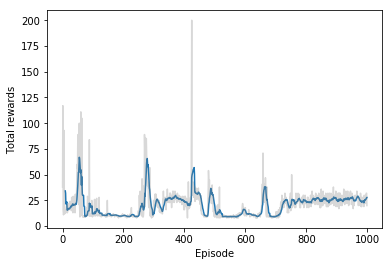

In [118]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Batch losses')

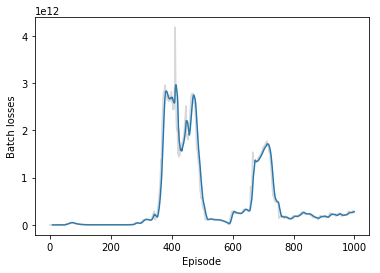

In [119]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Batch losses')

## Testing

Let's checkout how our trained agent plays the game.

In [21]:
import gym
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model-pg.ckpt')    
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        for _ in range(111111111111111111):
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
        # Closing the env
        print('total_reward: {:.2f}'.format(total_reward))
        env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 475.00


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.